# ML_Ng Homework 2

## Logistic Regression


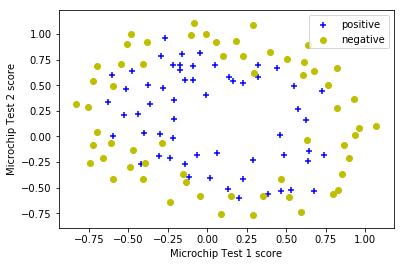

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def plot_data_np(X,y):
    # add position 0 to grab the indices
    pos = X[np.where(y == 1)[0]]
    neg = X[np.where(y == 0)[0]]

    #plt.figure(figsize=(6,6))
    plt.scatter(pos[:,0], 
                pos[:,1], 
                c='b', marker='+', label='positive')
    plt.scatter(neg[:,0], 
                neg[:,1], 
                c='y', marker='o', label='negative')
    plt.xlabel('Microchip Test 1 score')
    plt.ylabel('Microchip Test 2 score')

data = np.loadtxt('../ex2data2.txt', delimiter=',')
X = data[:, :-1]
y = data[:, -1:]
m = y.size
plot_data_np(X,y)
plt.legend()

### Panda implementation

In [104]:
data_pd = pd.read_csv('../ex2data2.txt', header=None, names=[
        'Microchip Test 1', 'Microchip Test 2', 'Admitted'])
data_pd.head()

,Microchip Test 1,Microchip Test 2,Admitted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


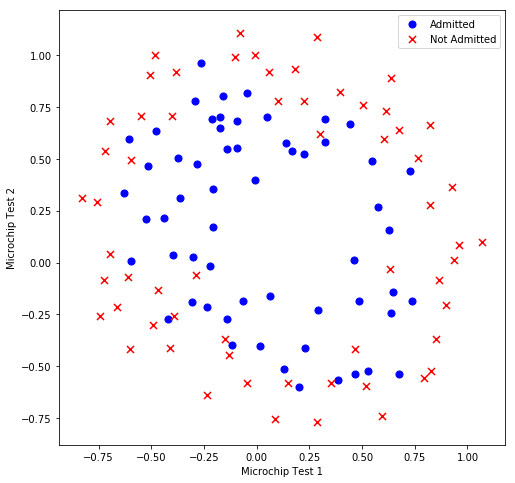

In [105]:
def plot_data_pd(data):
    positive = data[data['Admitted'].isin([1])]  
    negative = data[data['Admitted'].isin([0])]
    fig, ax = plt.subplots(figsize=(8,8))  
    ax.scatter(positive['Microchip Test 1'], positive['Microchip Test 2'], s=50, c='b', marker='o', label='Admitted')  
    ax.scatter(negative['Microchip Test 1'], negative['Microchip Test 2'], s=50, c='r', marker='x', label='Not Admitted')  
    ax.legend()  
    ax.set_xlabel('Microchip Test 1')  
    ax.set_ylabel('Microchip Test 2') 

plot_data_pd(data_pd)

## Part 1: Regularized Logistic Regression

### Add polynomial features

*Note that mapFeature also adds a column of ones for us, so the intercept term is handled*

Feature mapping function to polynomial features

   MAPFEATURE(X1, X2) maps the two input features
   to quadratic features used in the regularization exercise.

   Returns a new feature array with more features, comprising of 
   X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..

   Inputs X1, X2 must be the same size. 
   
   Note that mapFeature also adds a column of ones for us, so the intercept term is handled

In [106]:
def map_feature(X1,X2, degrees=6):
    out = np.ones((X1.size))
    for i in range(1, degrees+1):
        for j in range(0, i+1):
            out = np.column_stack((out, np.power(X1, i-j) * np.power(X2, j)))
    return out

X = map_feature(X[:,0], X[:,1])

### Compute and display initialized cost and gradient for regularized logistic regression
Compute cost and gradient for logistic regression with regularization
J = COSTFUNCTIONREG(theta, X, y, lambda) computes the cost of using
theta as the parameter for regularized logistic regression and the
gradient of the cost w.r.t. to the parameters. 

In [107]:
def sigmoid(z):
    g = np.zeros(np.atleast_1d(z).size)
    g = 1 / (1 + np.exp(-z))
    return g

def cost_fn(theta, X, y, lamb):
    m = y.size
    theta = np.matrix(theta).reshape((len(theta),1))
    h = sigmoid(X @ theta)
    J = 1/m * ((-y.T @ np.log(h)) - ((1 - y).T @ np.log(1 - h)))
    reg = lamb/(2*m) * np.sum(np.power(theta[1:,:],2))
    return J + reg
def grad_fn(theta, X, y, lamb):
    m = y.size
    theta = np.matrix(theta).reshape((len(theta),1))
    h = sigmoid(X @ theta)
    grad_reg = lamb/m * theta
    #grad_reg[0,:] = 0
    grad = 1/m * ((h-y).T @ X).T + grad_reg
    grad[0] = grad[0] - grad_reg[0]
    return grad

def cost_grad_function_reg(theta, X, y, lamb):
    J = cost_fn(theta,X,y,lamb)
    grad = grad_fn(theta,X,y,lamb)
    return J, grad

# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])
# Set regularization parameter lambda to 1
lamb = 1

cost, grad = cost_grad_function_reg(initial_theta, X, y, lamb)

print('Cost at initial theta (zeros): \n', cost);
print('Expected cost (approx): 0.693\n');
print('Gradient at initial theta (zeros) - first five values only:\n');
print( grad[:5]);
print('Expected gradients (approx) - first five values only:\n');
print(' 0.0085\n 0.0188\n 0.0001\n 0.0503\n 0.0115\n');

Cost at initial theta (zeros): 
 [[0.69314718]]
Expected cost (approx): 0.693

Gradient at initial theta (zeros) - first five values only:

[[8.47457627e-03]
 [1.87880932e-02]
 [7.77711864e-05]
 [5.03446395e-02]
 [1.15013308e-02]]
Expected gradients (approx) - first five values only:

 0.0085
 0.0188
 0.0001
 0.0503
 0.0115



Compute and display cost and gradient with all ones and lamba of 10

In [108]:
test_theta = np.ones(X.shape[1])
lamb = 10
cost, grad = cost_grad_function_reg(test_theta, X, y, lamb)

print('\nCost at test theta (with lambda = 10):\n', cost);
print('Expected cost (approx): 3.16\n');
print('Gradient at test theta - first five values only:\n');
print(grad[:5]);
print('Expected gradients (approx) - first five values only:\n');
print(' 0.3460\n 0.1614\n 0.1948\n 0.2269\n 0.0922\n');


Cost at test theta (with lambda = 10):
 [[3.16450933]]
Expected cost (approx): 3.16

Gradient at test theta - first five values only:

[[0.34604507]
 [0.16135192]
 [0.19479576]
 [0.22686278]
 [0.09218568]]
Expected gradients (approx) - first five values only:

 0.3460
 0.1614
 0.1948
 0.2269
 0.0922



### Solve using SciPy's Optimize
This result is calculated with fmin_tnc.

In [109]:
def predict(theta, X):
    p = sigmoid(X.dot(theta))
    return np.where(p >= 0.5, 1, 0)

m,n = X.shape
theta = np.zeros(n)
lamb = 1

import scipy.optimize as opt 
result = opt.fmin_tnc(func=cost_fn, x0=theta, fprime=grad_fn, args=(X, y, lamb))  
theta_min = np.matrix(result[0]).reshape(len(result[0]),1)
predictions = predict(theta_min, X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]  
accuracy = (sum(map(int, correct)) % len(correct))  
print ('TNC accuracy = {0}%'.format(accuracy)  )
print(f'result object: \n {result}')

TNC accuracy = 98%
result object: 
 (array([ 1.27271025,  0.62529964,  1.18111686, -2.01987398, -0.91743189,
       -1.43166926,  0.12393228, -0.36553118, -0.35725405, -0.17516291,
       -1.45817008, -0.05098418, -0.61558559, -0.27469165, -1.192713  ,
       -0.24217841, -0.20603303, -0.04466177, -0.27778946, -0.29539514,
       -0.45645982, -1.04319154,  0.02779374, -0.29244864,  0.01555759,
       -0.32742403, -0.14389149, -0.92467489]), 32, 1)


Try using BFGS, without f-prime/grad_fn

In [110]:
result = opt.fmin_bfgs(cost_fn, theta, args=(X, y, lamb), maxiter=500, disp=False)  
predictions = predict(theta_min, X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]  
accuracy = (sum(map(int, correct)) % len(correct))  
print ('BFGS accuracy = {0}%'.format(accuracy)  )
print(f'result object: \n {result}')

BFGS accuracy = 98%
result object: 
 [ 1.27268736  0.62557014  1.18096647 -2.01919806 -0.91761463 -1.4319422
  0.12375921 -0.36513089 -0.35703382 -0.17485794 -1.45843782 -0.05129662
 -0.6160394  -0.27464122 -1.19282567 -0.24270343 -0.20569996 -0.04499741
 -0.27782721 -0.29525826 -0.45613286 -1.04377819  0.02762835 -0.29265643
  0.015434   -0.32759307 -0.14389212 -0.92460106]


Try using with generic minimize function that defaults to BFGS, L-BFGS-B, SLSQP, depending if the problem has constraints or bounds.

In [111]:
result = opt.minimize(cost_fn, theta, args=(X, y, lamb))  
predictions = predict(theta_min, X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]  
accuracy = (sum(map(int, correct)) % len(correct))  
print ('Minimize accuracy = {0}%'.format(accuracy)  )
print(f'result object: \n {result}')

Minimize accuracy = 98%
result object: 
       fun: 0.5290027422851183
 hess_inv: array([[ 1.07924974e+01,  1.00369739e+00,  1.21087835e+00,
        -8.74680759e+00, -2.24618126e+00, -1.30924384e+01,
         7.86199612e-01, -1.64736449e+00, -2.52102246e-01,
        -6.51473098e-01, -4.71987029e+00,  2.57843211e+00,
        -4.03253294e+00,  1.02155152e-01, -5.05634159e+00,
        -6.75145550e-02, -2.66098170e-02,  8.81678599e-01,
        -1.68403372e+00, -5.53207486e-01,  2.14115031e+00,
        -2.31240062e+00,  2.02880392e+00, -1.59333705e+00,
         1.32526475e+00, -1.98960681e+00,  2.79334019e-01,
         5.95681937e-01],
       [ 1.00369739e+00,  1.28886583e+01,  4.31805057e+00,
        -6.95945950e+00, -7.08107004e+00, -4.85102605e-03,
         1.69122861e+00,  7.18403174e-01,  2.99578009e+00,
        -3.00911268e+00, -3.78299049e+00, -2.06570769e-01,
         9.68621743e-01, -1.53860515e+00, -7.57372121e-01,
        -5.27801158e-01,  5.66039718e-01,  1.55023416e+00,
       

### Solve using Scikit-Learn's OveVsRestClassifier

In [112]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

classifier = OneVsRestClassifier(LogisticRegression(penalty='l2', C=lamb)).fit(X, y)
print( 'Coefficents: \n', classifier.coef_)
print( 'Intercept: ', classifier.intercept_)
print( 'Accuracy:', classifier.score(X,y))

Coefficents: 
 [[ 0.60181257  0.61262932  1.17369724 -1.94159987 -0.91652206 -1.34600069
   0.12538359 -0.3671774  -0.35087379 -0.17439841 -1.43997026 -0.04973447
  -0.6106624  -0.27187562 -1.17708203 -0.24264323 -0.2065488  -0.04393776
  -0.27907087 -0.2909125  -0.46305003 -1.03941697  0.02853522 -0.29251337
   0.01648987 -0.32818075 -0.14074991 -0.92845357]]
Intercept:  [[0.60181257]]
Accuracy: 0.8305084745762712


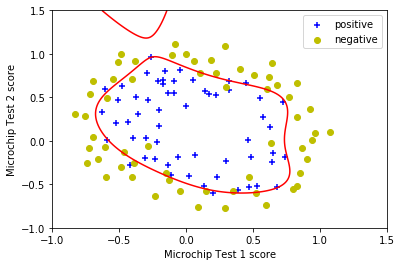

In [116]:
def draw_boundary(classifier):
    dim = np.linspace(-1, 1.5, 1000)
    dx, dy = np.meshgrid(dim, dim)
    v = map_feature(dx.flatten(), dy.flatten())
    z = (np.dot(classifier.coef_, v.T) + classifier.intercept_).reshape(1000, 1000)
    CS = plt.contour(dx, dy, z, levels=[0], colors=['r'])

plot_data_np(X, y)
draw_boundary(classifier)
plt.legend();